In [1]:
# read in the tables
import pandas as pd
from config import MODELS_LIST
base_path = "cross/"

stopping_rule_results_summary = pd.read_csv(base_path + "stopping_rule_results_summary.csv")
results_summary = pd.read_csv(base_path + "results_summary.csv")
results_prompt_intervention_summary = pd.read_csv(base_path + "results_prompt_intervention_summary.csv")
results_prompt_intervention_criticism_summary = pd.read_csv(base_path + "results_prompt_intervention_criticism_summary.csv")

# sort the models according to MODELS_LIST
def sort_df_by_model_list(df, model_list):
    df['model_name'] = pd.Categorical(df['model_name'], categories=model_list, ordered=True)
    df = df.sort_values('model_name')
    return df
stopping_rule_results_summary = sort_df_by_model_list(stopping_rule_results_summary, MODELS_LIST)
results_summary = sort_df_by_model_list(results_summary, MODELS_LIST)
results_prompt_intervention_summary = sort_df_by_model_list(results_prompt_intervention_summary, MODELS_LIST)
results_prompt_intervention_criticism_summary = sort_df_by_model_list(results_prompt_intervention_criticism_summary, MODELS_LIST)

stopping_rule_results_summary = stopping_rule_results_summary[
    (stopping_rule_results_summary['stopping_rule'] == 'Length') |
    (
        (stopping_rule_results_summary['lazy_interval'] == "250")  & (stopping_rule_results_summary['ablation'] == "none") 
    )
]

In [2]:
# change 'early_stopping_rate_well_posed' to 'fpr'
stopping_rule_results_summary = stopping_rule_results_summary.rename(columns={"early_stopping_rate_well_posed": "fpr"})

In [3]:
stopping_rule_results_summary = stopping_rule_results_summary.rename(columns={"early_stopping_rate_ill_posed": "power"})
results_summary = results_summary.rename(columns={"avg_llm_abstention_ill_posed": "power"})
results_prompt_intervention_summary = results_prompt_intervention_summary.rename(columns={"avg_llm_abstention_ill_posed": "power"})
results_prompt_intervention_criticism_summary = results_prompt_intervention_criticism_summary.rename(columns={"avg_llm_abstention_ill_posed": "power"})

results_summary['fpr'] = 0

# the FPR of Confidence is 
results_prompt_intervention_summary['fpr'] = results_summary['avg_correct_well_posed'] - results_prompt_intervention_summary['avg_correct_well_posed']
# the FPR of Criticism is
results_prompt_intervention_criticism_summary['fpr'] = results_prompt_intervention_summary['avg_correct_well_posed'] - results_prompt_intervention_criticism_summary['avg_correct_well_posed']

In [4]:
# create a table that compares the fpr and power of all methods 
# notice that for stopping_rule_results_summary, there are 3 kinds of stopping rules -- so grouping is needed on the stopping_rule column

# create one comparison table per dataset
datasets = sorted(
    set(results_summary['dataset'].dropna().unique())
)

comparison_tables = {}
methods_sr = ['Length', 'Renewal', 'Maxwise']


for ds in datasets:
    rows = []
    rows.append({
        'method': 'No Intervention',
        'fpr': results_summary.loc[results_summary['dataset'] == ds, 'fpr'].mean() * 100,
        'power': results_summary.loc[results_summary['dataset'] == ds, 'power'].mean() * 100
    })
    rows.append({
        'method': 'Confidence',
        'fpr': results_prompt_intervention_summary.loc[results_prompt_intervention_summary['dataset'] == ds, 'fpr'].mean() * 100,
        'power': results_prompt_intervention_summary.loc[results_prompt_intervention_summary['dataset'] == ds, 'power'].mean() * 100
    })
    rows.append({
        'method': 'Criticism',
        'fpr': results_prompt_intervention_criticism_summary.loc[results_prompt_intervention_criticism_summary['dataset'] == ds, 'fpr'].mean() * 100,
        'power': results_prompt_intervention_criticism_summary.loc[results_prompt_intervention_criticism_summary['dataset'] == ds, 'power'].mean() * 100
    })

    for sr in methods_sr:
        df_sr = stopping_rule_results_summary.loc[
            (stopping_rule_results_summary['dataset'] == ds) &
            (stopping_rule_results_summary['stopping_rule'] == sr)
        ]
        rows.append({
            'method': sr,
            'fpr': df_sr['fpr'].mean(),
            'power': df_sr['power'].mean()
        })

    comparison_tables[ds] = pd.DataFrame(rows)

In [5]:
# Order and pretty labels exactly like your screenshot
method_order = [
    "No Intervention",
    "Confidence",
    "Criticism",
    "Length",
    "Renewal",
    "Maxwise",
]

dataset_order = ['gpqa', 'hle']#['mc', 'umwp', 'mip', 'mmlu']

# 1. Combine all datasets into a wide MultiIndex table
wide = pd.concat(
    {ds: comparison_tables[ds].set_index("method") for ds in dataset_order},
    axis=1
)

# reorder rows
wide = wide.reindex(method_order)

# 2. Format numbers as percentages like the LaTeX figure
def fmt(x):
    if pd.isna(x):
        return ""
    return f"{x:.2f}\\%"

wide = wide.applymap(fmt)

# 3. Set pretty top-level labels (dataset | FPR Power)
metric_labels = {"fpr": "FPR", "power": "Power", "soft_upperbound": "Soft UB"}
dataset_labels = {
    'mmlu': 'MMLU',
    'mc': 'GSM-MC',
    'mip': 'MiP',
    'umwp': 'UMWP',
    'gpqa': 'GPQA',
    'hle': 'HLE',
}

wide.columns = pd.MultiIndex.from_tuples(
    [(dataset_labels[ds], metric_labels[metric]) for ds, metric in wide.columns]
)

wide.index.name = None

latex = wide.to_latex(
    escape=False,
    multicolumn=True,
    multicolumn_format="c",
    column_format="l" + "cc"*len(dataset_order),
    bold_rows=False,
)

# Now replace the empty top-left corner with "Stopping Rule"
latex = latex.replace(
    "{} & FPR",  # beginning of second header row
    "Stopping Rule & FPR"
)

# change the first cell after \toprule to multirow{2}{*}{Stopping Rule}
latex = latex.replace(
    " & \multicolumn{2}{c}{GPQA}",
    " \\multirow{2}{*}{Stopping Rule} & \multicolumn{2}{c}{GPQA}"
)


print("========================================")
print(" LaTeX TABLE OUTPUT")
print("========================================")
print(latex)


<>:63: SyntaxWarning: invalid escape sequence '\m'
<>:64: SyntaxWarning: invalid escape sequence '\m'
<>:63: SyntaxWarning: invalid escape sequence '\m'
<>:64: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_546506/2111993146.py:63: SyntaxWarning: invalid escape sequence '\m'
  " & \multicolumn{2}{c}{GPQA}",
/tmp/ipykernel_546506/2111993146.py:64: SyntaxWarning: invalid escape sequence '\m'
  " \\multirow{2}{*}{Stopping Rule} & \multicolumn{2}{c}{GPQA}"
/tmp/ipykernel_546506/2111993146.py:28: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  wide = wide.applymap(fmt)


 LaTeX TABLE OUTPUT
\begin{tabular}{lcccc}
\toprule
 \multirow{2}{*}{Stopping Rule} & \multicolumn{2}{c}{GPQA} & \multicolumn{2}{c}{HLE} \\
 & FPR & Power & FPR & Power \\
\midrule
No Intervention & 0.00\% & 0.12\% & 0.00\% & 3.85\% \\
Confidence & 12.85\% & 5.57\% & -0.43\% & 3.95\% \\
Criticism & -0.55\% & 9.12\% & 0.33\% & 4.11\% \\
Length & 42.40\% & 32.14\% & 23.74\% & 10.91\% \\
Renewal & 1.37\% & 24.94\% & 4.76\% & 24.62\% \\
Maxwise & 2.56\% & 32.40\% & 5.96\% & 31.28\% \\
\bottomrule
\end{tabular}



In [6]:
from config import MODELS_SHORT_NAME

# metric can be "power" or "fpr"
def make_compact_tables(stopping_rule_results_summary, methods_sr,
                        metrics=("power", "fpr", "soft_upperbound")):
    compact_tables = {}

    for metric in metrics:
        for sr in methods_sr:
            df_sr = stopping_rule_results_summary[
                stopping_rule_results_summary["stopping_rule"] == sr
            ]

            # rows: model_name, columns: dataset, values: mean(metric)
            table = (
                df_sr.groupby(["model_name", "dataset"])[metric]
                    .mean()
                    .unstack("dataset")           # dataset names become columns
                    .reset_index()                # keep model_name as a column
                    .sort_values("model_name")
            )

            table.iloc[:, 1:] = (table.iloc[:, 1:]).round(2)

            compact_tables[f"{metric}_{sr}"] = table
            # replace model name with short names
            compact_tables[f"{metric}_{sr}"]['model_name'] = compact_tables[f"{metric}_{sr}"]['model_name'].map(MODELS_SHORT_NAME)

    return compact_tables

compact_tables = make_compact_tables(stopping_rule_results_summary, methods_sr)


def make_fpr_power_table(sr, compact_tables):
    """
    sr: stopping rule name, e.g. 'No Intervention'
    compact_tables: output of make_compact_tables(...)
                    must contain 'fpr_<sr>' and 'power_<sr>'
    returns: (latex_string, wide_dataframe)
    """
    # --- 1. get the compact tables for this stopping rule ---
    df_power = compact_tables[f"power_{sr}"].set_index("model_name")
    df_fpr   = compact_tables[f"fpr_{sr}"].set_index("model_name")
    df_soft_upperbound = compact_tables[f'soft_upperbound_{sr}'].set_index("model_name")

    # ensure dataset column order
    df_power = df_power[dataset_order]
    df_fpr   = df_fpr[dataset_order]
    df_soft_upperbound = df_soft_upperbound[dataset_order]

    # --- 2. combine into a wide table with MultiIndex columns (dataset, metric) ---
    combined = pd.concat(
        {
            ds: pd.DataFrame({
                "fpr": df_fpr[ds],
                "power": df_power[ds],
                "soft_upperbound": df_soft_upperbound[ds],
            })
            for ds in dataset_order
        },
        axis=1
    )

    # combined.columns is like: MultiIndex([(ds, 'fpr'), (ds, 'power'), ...])

    # pretty labels on columns
    col_tuples = [
        (dataset_labels[ds], metric_labels[metric])
        for ds, metric in combined.columns
    ]
    combined.columns = pd.MultiIndex.from_tuples(col_tuples)

    # --- 3. format numbers and add the model name as the first column ---
    formatted = combined.applymap(fmt)

    # put model_name back as a first column
    formatted.insert(0, ('', 'Model'), formatted.index)

    # reset index so we don't print row numbers
    formatted = formatted.reset_index(drop=True)

    # set final MultiIndex columns (first column has top-level '' and 'Model' second-level)
    formatted.columns = pd.MultiIndex.from_tuples(
        [('', 'Model')] + col_tuples
    )

    # add an average at the end
    # combined is still numeric with columns = col_tuples
    avg_numeric = combined.mean(axis=0)          # mean over models for each (dataset, metric)
    avg_formatted = avg_numeric.apply(fmt)

    # build a dict for the new row
    avg_row = {('', 'Model'): 'Average'}
    for col in col_tuples:
        avg_row[col] = avg_formatted[col]

    # append the Average row
    formatted = pd.concat([formatted, pd.DataFrame([avg_row])], ignore_index=True)

    # --- 4. LaTeX export ---
    latex = formatted.to_latex(
        index=False,
        escape=False,
        multicolumn=True,
        multicolumn_format="c",
        column_format="l" + "ccc"*len(dataset_order),  # Model + 3 per dataset
        bold_rows=False,
    )

    return latex, formatted

sr = "Renewal"
latex_str, wide_df = make_fpr_power_table(sr, compact_tables)
print(latex_str)

\begin{tabular}{lcccccc}
\toprule
 & \multicolumn{3}{c}{GPQA} & \multicolumn{3}{c}{HLE} \\
Model & FPR & Power & Soft UB & FPR & Power & Soft UB \\
\midrule
DeepSeek-7B & 0.00\% & 13.64\% & 55.43\% & 2.63\% & 15.79\% & 14.47\% \\
DeepSeek-14B & 2.10\% & 29.02\% & 52.10\% & 8.55\% & 26.97\% & 42.11\% \\
DeepSeek-32B & 1.75\% & 26.57\% & 55.94\% & 4.61\% & 25.00\% & 32.24\% \\
QwQ-32B & 0.70\% & 16.78\% & 61.19\% & 2.63\% & 26.32\% & 44.08\% \\
Qwen3-8B & 3.85\% & 41.61\% & 70.98\% & 7.10\% & 18.52\% & 16.98\% \\
Qwen3-14B & 2.10\% & 42.66\% & 74.83\% & 8.55\% & 42.76\% & 60.53\% \\
Qwen3-32B & 1.05\% & 33.57\% & 61.54\% & 5.92\% & 26.97\% & 42.76\% \\
Nemotron-7B & 1.40\% & 17.13\% & 58.39\% & 2.63\% & 20.39\% & 39.47\% \\
Nemotron-14B & 0.35\% & 15.03\% & 65.03\% & 1.97\% & 18.42\% & 42.11\% \\
MiMo-7B & 0.70\% & 26.57\% & 60.84\% & 4.61\% & 32.24\% & 41.45\% \\
Skywork-7B & 2.45\% & 23.43\% & 58.74\% & 4.61\% & 25.66\% & 36.84\% \\
Skywork-32B & 0.00\% & 13.29\% & 65.38\% & 3.29\% & 1

/tmp/ipykernel_546506/4241001621.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_sr.groupby(["model_name", "dataset"])[metric]
/tmp/ipykernel_546506/4241001621.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_sr.groupby(["model_name", "dataset"])[metric]
/tmp/ipykernel_546506/4241001621.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_sr.groupby(["model_name", "dataset"])[metric]
/tmp/ipykernel_5465

In [7]:
sr = "Maxwise"
latex_str, wide_df = make_fpr_power_table(sr, compact_tables)
print(latex_str)

\begin{tabular}{lcccccc}
\toprule
 & \multicolumn{3}{c}{GPQA} & \multicolumn{3}{c}{HLE} \\
Model & FPR & Power & Soft UB & FPR & Power & Soft UB \\
\midrule
DeepSeek-7B & 8.74\% & 45.80\% & 59.99\% & 13.82\% & 46.71\% & 22.37\% \\
DeepSeek-14B & 2.80\% & 32.17\% & 52.10\% & 11.18\% & 34.87\% & 46.05\% \\
DeepSeek-32B & 3.85\% & 36.36\% & 55.94\% & 7.89\% & 36.84\% & 39.47\% \\
QwQ-32B & 1.05\% & 26.22\% & 61.19\% & 3.95\% & 32.24\% & 44.08\% \\
Qwen3-8B & 1.40\% & 43.36\% & 70.98\% & 3.70\% & 14.20\% & 16.67\% \\
Qwen3-14B & 2.45\% & 48.95\% & 74.83\% & 9.21\% & 48.03\% & 61.84\% \\
Qwen3-32B & 2.10\% & 42.31\% & 61.54\% & 5.92\% & 36.18\% & 42.76\% \\
Nemotron-7B & 2.10\% & 26.57\% & 58.39\% & 3.95\% & 28.29\% & 39.47\% \\
Nemotron-14B & 0.35\% & 13.64\% & 65.03\% & 2.63\% & 19.08\% & 42.11\% \\
MiMo-7B & 1.40\% & 27.27\% & 60.84\% & 2.63\% & 30.26\% & 41.45\% \\
Skywork-7B & 3.50\% & 29.02\% & 58.74\% & 3.29\% & 28.95\% & 36.84\% \\
Skywork-32B & 1.05\% & 17.13\% & 65.38\% & 3.29\% &

/tmp/ipykernel_546506/4241001621.py:74: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  formatted = combined.applymap(fmt)


=== Stopping Rule: Renewal ===
Coefficient (slope): 0.4702
=== Stopping Rule: Maxwise ===
Coefficient (slope): 0.5897


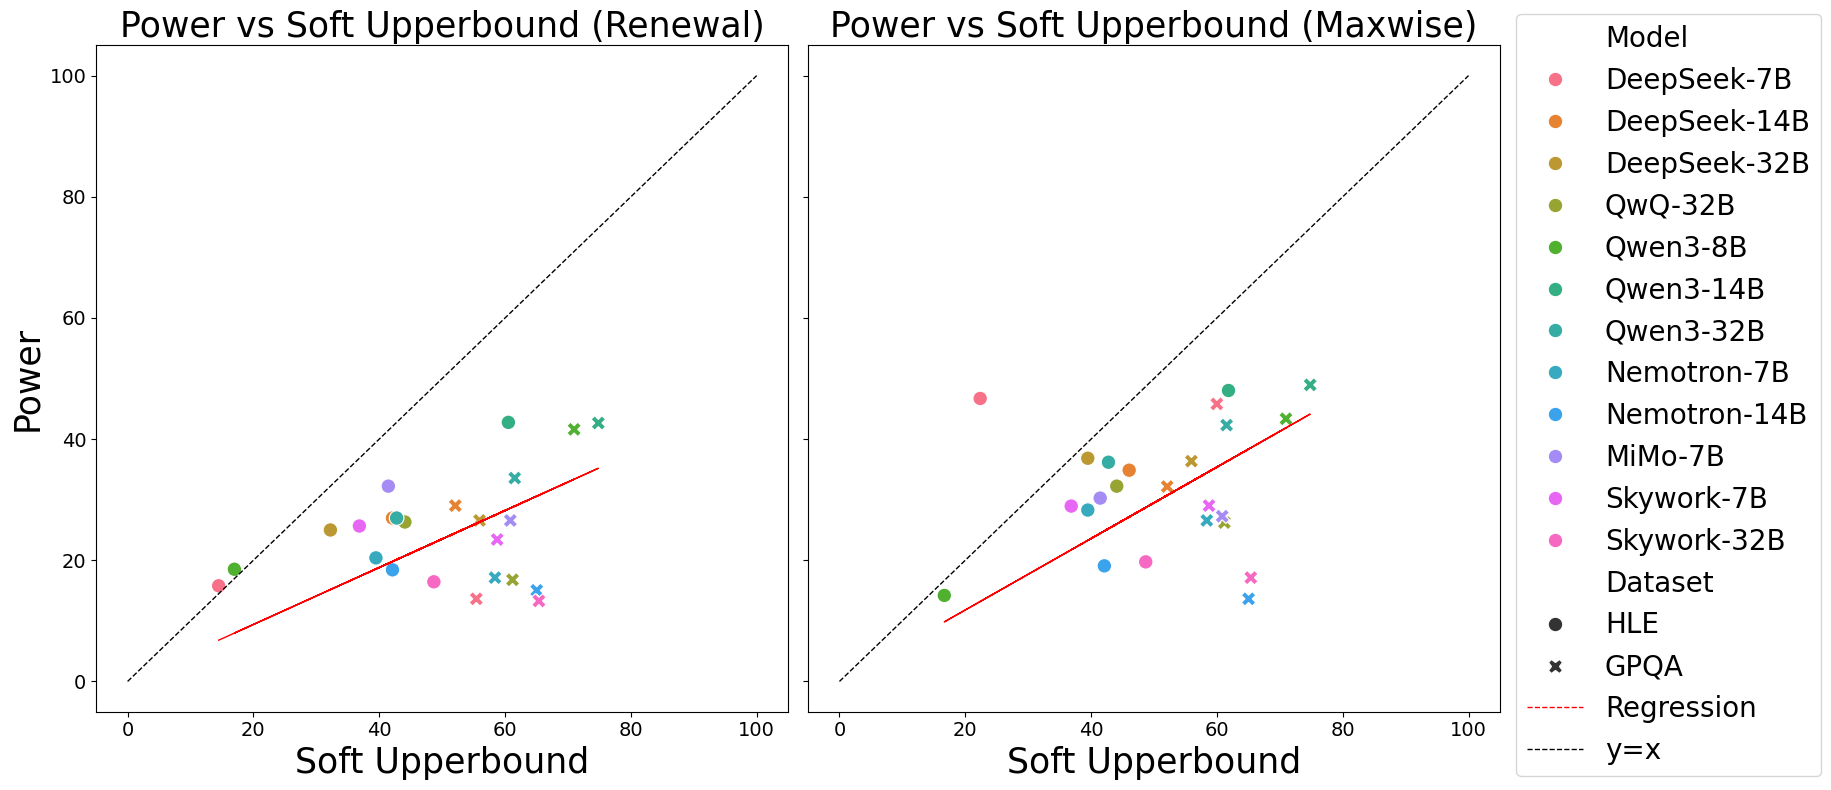

In [8]:
import matplotlib as mpl

# Global font settings for all figures
mpl.rcParams.update({
    "axes.titlesize": 18,
    "axes.labelsize": 16,
    "xtick.labelsize": 14,
    "ytick.labelsize": 14,
    "legend.fontsize": 14,
    "figure.titlesize": 18,
})

from config import MODELS_SHORT_NAME
import matplotlib.pyplot as plt
import seaborn as sns

# Dataset rename map (same as what you used earlier)
DATASET_ALIASES = {
    "hle": "HLE",
    "gpqa": "GPQA",
}

# Only plot Renewal + Maxwise
target_srs = [
    "Renewal",
    "Maxwise",
]

fig, axes = plt.subplots(1, 2, figsize=(16, 8), sharex=True, sharey=True)

all_handles = []
all_labels = []

for ax, sr in zip(axes, target_srs):

    df_sr = stopping_rule_results_summary[
        stopping_rule_results_summary["stopping_rule"] == sr
    ][["model_name", "dataset", "power", "soft_upperbound"]]
    
    df_sr["model_name"] = df_sr["model_name"].map(MODELS_SHORT_NAME)
    df_sr["dataset"] = df_sr["dataset"].map(DATASET_ALIASES)
    # rename model_name and dataset for better visualization
    df_sr = df_sr.rename(columns={"model_name": "Model", "dataset": "Dataset"})

    # Scatterplot
    sns.scatterplot(
        data=df_sr,
        x="soft_upperbound",
        y="power",
        hue="Model",
        style="Dataset",
        s=110,
        ax=ax,
        legend=True     # we remove it right after collecting handles
    )

    # Remove subplot legend (so only a single main legend remains)
    if ax.legend_:
        ax.legend_.remove()

    # Diagonal y=x
    ax.plot([0, 100], [0, 100], "k--", linewidth=1)
    
    # fit a linear regression line through the origin
    import numpy as np
    from sklearn.linear_model import LinearRegression
    X = df_sr["soft_upperbound"].values.reshape(-1, 1)  

    y = df_sr["power"].values
    model = LinearRegression(fit_intercept=False)
    model.fit(X, y)
    y_pred = model.predict(X)
    ax.plot(X, y_pred, color="r", linestyle="-", linewidth=1, label="Regression")
    print(f"=== Stopping Rule: {sr} ===")
    print(f"Coefficient (slope): {model.coef_[0]:.4f}")

    ax.set_title(f"Power vs Soft Upperbound ({sr})")
    ax.set_xlabel("Soft Upperbound")
    ax.set_ylabel("Power")
    # increase font size for better readability
    
    ax.title.set_fontsize(25)
    ax.xaxis.label.set_fontsize(25)
    ax.yaxis.label.set_fontsize(25)

    # Collect legend entries
    handles, labels = ax.get_legend_handles_labels()
    all_handles.extend(handles)
    all_labels.extend(labels)

# Deduplicate legend entries
unique = dict(zip(all_labels, all_handles))

# add the y=x line to the legend
unique["y=x"] = plt.Line2D([0], [0], color="k", linestyle="--", linewidth=1)
# add best fit line to the legend
unique["Regression"] = plt.Line2D([0], [0], color="r", linestyle="--", linewidth=1)



# Global legend on the right
fig.legend(
    unique.values(),
    unique.keys(),
    loc="center right",
    bbox_to_anchor=(1.15, 0.5),
    fontsize=20
)

plt.tight_layout(rect=[0, 0, 0.95, 1])  # add right margin for legend
plt.savefig("figs/power_vs_upperbound_sci.png", dpi=300)
plt.show()